### Tract modelling

## Model then push forward

This script proceeds in four steps:

1. Fit a tract-level model of infogroup bias reduction using 2010 data
2. Project the model to all available years 
3. Construct 5-year average adjusted estimates
4. Compare 5-year average adjusted estimates to ACS

---

### Setup

In [96]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(lme4)
    library(brms)
    library(patchwork)
    library(parallel)
    library(ggridges)
})

In [2]:
source("../functions/utils.R")

In [3]:
dec <- readRDS("../data/prepped_data/tracts_decennial.rds")
acs_5 <- readRDS("../data/prepped_data/tracts_5_acs.rds")

In [4]:
names(dec) <- sub("_$", "", names(dec))
names(acs_5) <- sub("_$", "", names(acs_5))

In [5]:
n_cores <- detectCores() - 1
n_cores

[1] 7

---

### Fit model

In [6]:
# Formula
desc1 <- "Bayesian random slopes with covariates"
f1 <- formula(log(chh) ~ 1 + log(ig_count_imptd) + (1 + log(ig_count_imptd) | countyid) +
              pown + pfemale + page_1824 + page_under18 + page_65plus + pnw + pblack + 
              phisp + pasian + pnative + pvacant + phu_othervacant + pgq)

formulas <- list(f1)

In [7]:
# Set Bayesian priors here
my_prior <- c(
    set_prior("normal(0, 5)", class = "Intercept"),
    set_prior("normal(0, 5)", class = "b"),
    set_prior("student_t(3, 0, 5)", class = "sd"),
    set_prior("lkj(2)", class = "cor")
)

In [8]:
# STAN code
print(make_stancode(f1, dec, prior = my_prior))

// generated with brms 2.14.4
functions {
  /* turn a vector into a matrix of defined dimension 
   * stores elements in row major order
   * Args: 
   *   X: a vector 
   *   N: first dimension of the desired matrix
   *   K: second dimension of the desired matrix 
   * Returns: 
   *   a matrix of dimension N x K 
   */ 
  matrix as_matrix(vector X, int N, int K) { 
    matrix[N, K] Y; 
    for (i in 1:N) {
      Y[i] = to_row_vector(X[((i - 1) * K + 1):(i * K)]); 
    }
    return Y; 
  } 
 /* compute correlated group-level effects
  * Args: 
  *   z: matrix of unscaled group-level effects
  *   SD: vector of standard deviation parameters
  *   L: cholesky factor correlation matrix
  * Returns: 
  *   matrix of scaled group-level effects
  */ 
  matrix scale_r_cor(matrix z, vector SD, matrix L) {
    // r is stored in another dimension order than z
    return transpose(diag_pre_multiply(SD, L) * z);
  }
}
data {
  int<lower=1> N;  // total number of observations
  vector[N] Y;  // r

In [9]:
# Rerunning this model can take several days. To rerun it, 
# delete the model file or set a different path in fit_models()
models <- fit_models(
    formulas, 
    dec, 
    "../models/tract/final_model_tract.rds", 
    cores = n_cores,
    prior = my_prior,
    chains = 4,
    iter = 8000,
    warmup = 1000,
    thin = 3,
    bayes = "some"
)

Fitting model 1

Model fit complete. Runtime:  4.550262

In [10]:
summary(models[[1]])

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log(chh) ~ 1 + log(ig_count_imptd) + (1 + log(ig_count_imptd) | countyid) + pown + pfemale + page_1824 + page_under18 + page_65plus + pnw + pblack + phisp + pasian + pnative + pvacant + phu_othervacant + pgq 
   Data: data (Number of observations: 72067) 
Samples: 4 chains, each with iter = 8000; warmup = 1000; thin = 3;
         total post-warmup samples = 9334

Group-Level Effects: 
~countyid (Number of levels: 3139) 
                                 Estimate Est.Error l-95% CI u-95% CI Rhat
sd(Intercept)                        1.61      0.03     1.56     1.67 1.00
sd(logig_count_imptd)                0.22      0.00     0.21     0.23 1.00
cor(Intercept,logig_count_imptd)    -1.00      0.00    -1.00    -1.00 1.00
                                 Bulk_ESS Tail_ESS
sd(Intercept)                        3479     5485
sd(logig_count_imptd)                3485     5477
cor(Intercept,logig_count_imptd)     4819     7350

P

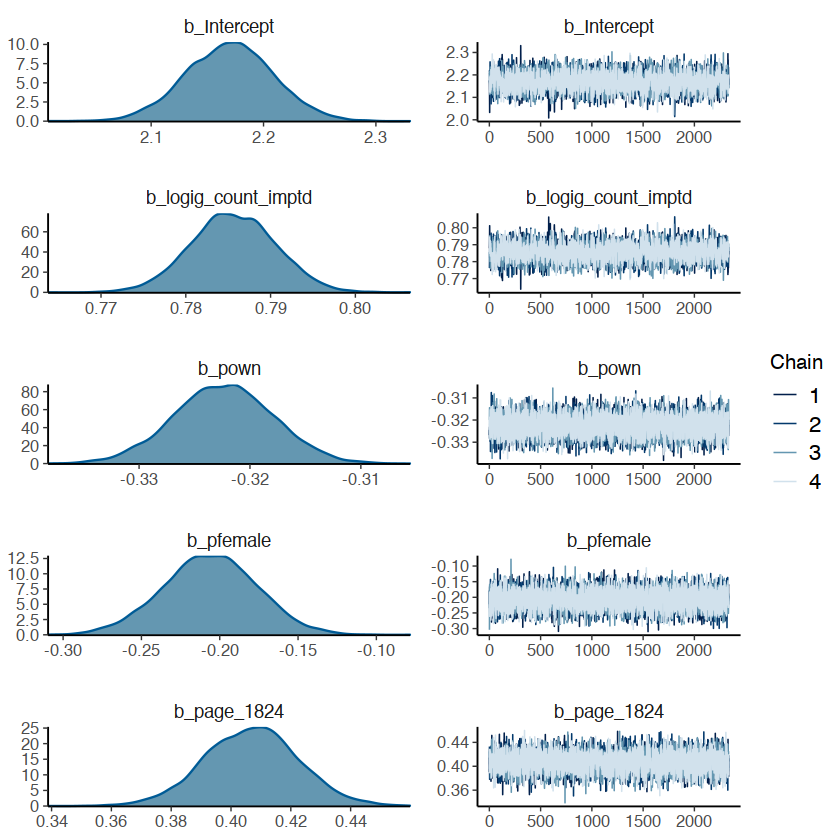

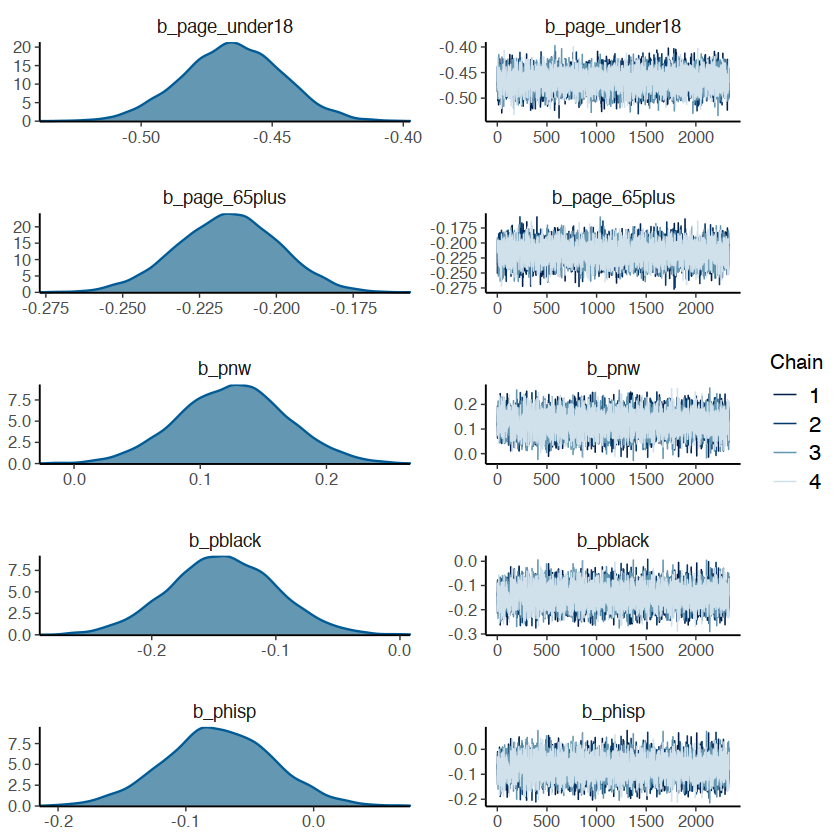

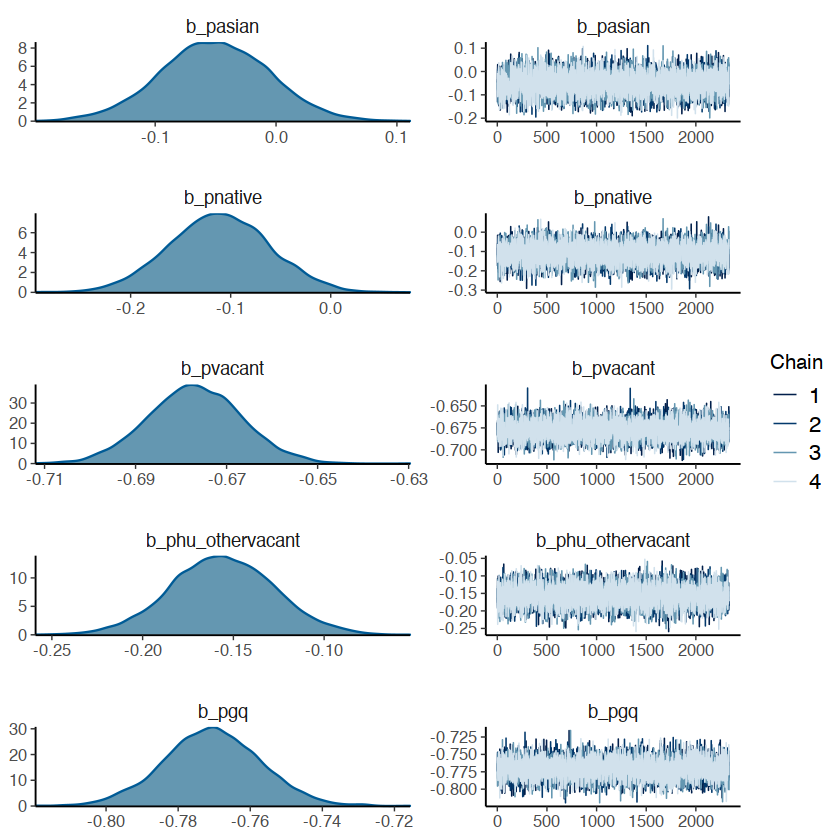

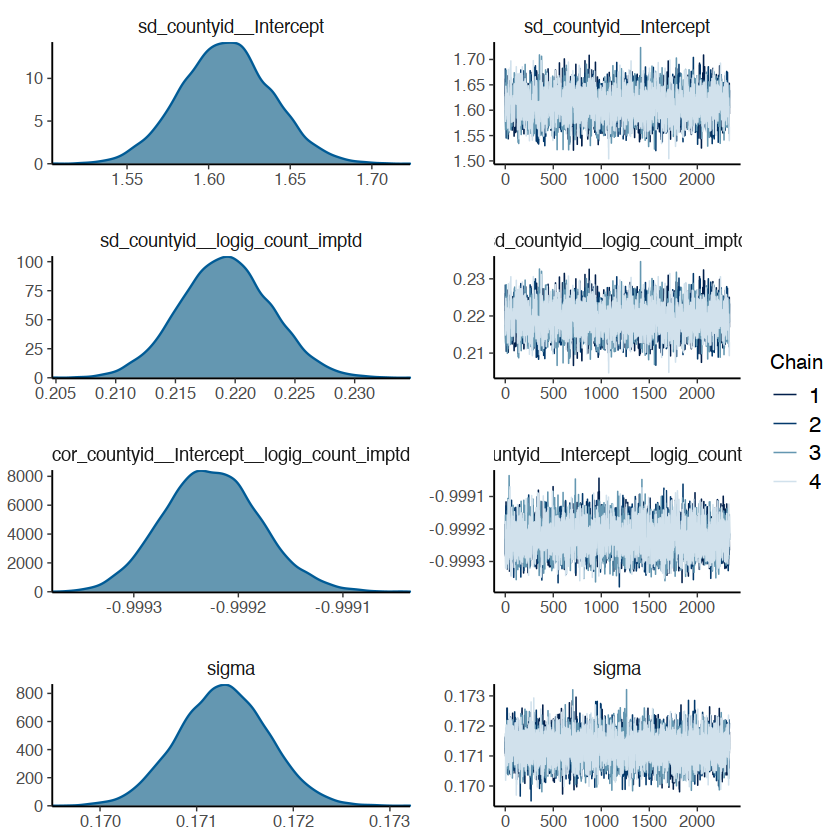

In [11]:
plot(models[[1]])

---

### Checking in-sample errors

In [21]:
results <- get_preds(models, dec, n_samples = 5000)
head(results)

tractid,year,ig_count,lead,lag,ig_count_imptd,geoid,chh,pown,pfemale,⋯,ruca_1,ruca_2,area_sqmi,chh_density,lprd_1,lu90_1,ll90_1,prd_1,u90_1,l90_1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
02013000100,2010,561,585,564,561,2.013e+09,553,0.5153707,0.3336517,⋯,10,10,6981.940000,0.0792044,6.317153,6.546441,6.088521,553.9935,696.7599,440.7689
02016000100,2010,249,247,243,249,2.016e+09,285,0.5754386,0.3856540,⋯,10,10,3300.134000,0.0863601,5.836627,6.042987,5.628889,342.6216,421.1491,278.3527
02016000200,2010,375,362,383,375,2.016e+09,927,0.2448759,0.3155850,⋯,10,10,1090.140000,0.8503496,6.507347,6.668303,6.343199,670.0462,787.0588,568.6122
02020000101,2010,971,1010,906,971,2.020e+09,1946,0.8386434,0.4844840,⋯,2,2,617.325700,3.1523070,7.102537,7.162242,7.041980,1215.0463,1289.7990,1143.6498
02020000102,2010,2847,2814,2858,2847,2.020e+09,2010,0.6706468,0.4856437,⋯,2,2,65.166130,30.8442400,7.797007,7.857397,7.737440,2433.3091,2584.7831,2292.5950
02020000201,2010,1244,1283,1295,1244,2.020e+09,1535,0.5993485,0.5043796,⋯,2,2,1.274753,1204.1550000,7.359422,7.403855,7.314848,1570.9278,1642.3037,1502.4437


In [22]:
log_errors <- rbind(
  get_errors(log(results$chh), log(results$ig_count_imptd), "raw infogroup"),
  get_errors(log(results$chh), results$lprd_1, desc1)
)
log_errors

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
raw infogroup,7.28442,0.4956064,7.155868,0.5581449,0.8577973,0.7358162,0.3148139,0.1967987,0.13682351
Bayesian random slopes with covariates,7.28442,0.4956064,7.284428,0.4636008,0.9413953,0.8862251,0.1671957,0.1024922,0.06477382


In [23]:
errors <- rbind(
  get_errors(results$chh, results$ig_count_imptd, "raw infogroup"),
  get_errors(results$chh, results$prd_1, desc1)
)
errors

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
raw infogroup,1618.377,717.7878,1458.882,730.1240,0.8510302,0.7242523,426.2996,271.2341,187.50000
Bayesian random slopes with covariates,1618.377,717.7878,1597.825,661.6236,0.9354103,0.8749925,254.8016,156.7185,94.22388


---

### Use model to project to all years

Projecting to every tract in the dataset for every year

In [24]:
years <- unique(acs_5$year)
years

[1] 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019

In [ ]:
projections <- proj_by_year(acs_5, dec, models, "tractid", n_samples = 5000)

predictions for 2006



In [ ]:
saveRDS(projections, "../data/projections/tract_final.rds")

In [13]:
projections <- readRDS("../data/projections/tract_final.rds")
head(projections)

tractid,year,ig_count_imptd,chh,chh_moe,ig_count,lead,lag,geoid,pown,⋯,ruca_1,ruca_2,area_sqmi,chh_density,lprd_1,lu90_1,ll90_1,prd_1,u90_1,l90_1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
01001020100,2006,728,NA,NA,690,676,683,1.001e+09,0.7734488,⋯,1,1,3.787639,182.9636,6.635039,6.760415,6.508320,761.3090,863.0002,670.6986
01001020200,2006,997,NA,NA,1196,1153,1124,1.001e+09,0.6312248,⋯,1,1,1.289776,576.0692,6.896891,6.984192,6.808601,989.1942,1079.4338,905.6034
01001020300,2006,1208,NA,NA,1187,1156,1122,1.001e+09,0.7555733,⋯,1,1,2.065365,608.1249,7.157387,7.228469,7.086437,1283.5529,1378.1110,1195.6403
01001020400,2006,1636,NA,NA,1600,1562,1543,1.001e+09,0.7880372,⋯,1,1,2.464375,698.7572,7.448502,7.515767,7.381376,1717.2896,1836.7751,1605.7972
01001020500,2006,3237,NA,NA,3591,3626,3396,1.001e+09,0.6024008,⋯,1,1,4.400684,927.5830,8.182825,8.323777,8.040854,3578.9522,4120.6938,3105.2652
01001020600,2006,1117,NA,NA,1206,1148,1160,1.001e+09,0.7734554,⋯,1,1,3.096679,423.3567,7.046970,7.124330,6.970041,1149.3712,1241.8163,1064.2662


#### Make 5 year average of projections

In [35]:
projections_w_5year <- get_fiveyear(
    projections, 
    c("lprd_1", "prd_1", "ig_count_imptd", "lu90_1", "ll90_1", "u90_1", "l90_1"), 
    "tractid"
)

Averaging for 2010

Averaging for 2011

Averaging for 2012

Averaging for 2013

Averaging for 2014

Averaging for 2015

Averaging for 2016

Averaging for 2017

Averaging for 2018



In [36]:
head(projections_w_5year)

tractid,lprd_1_5year,prd_1_5year,ig_count_imptd_5year,lu90_1_5year,ll90_1_5year,u90_1_5year,l90_1_5year,year,ig_count_imptd,⋯,ruca_1,ruca_2,area_sqmi,chh_density,lprd_1,lu90_1,ll90_1,prd_1,u90_1,l90_1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
01001020100,6.626839,755.9689,722.6,6.754979,6.499435,859.0676,665.7835,2010,690,⋯,1,1,3.787639,182.9636,6.581773,6.716273,6.447133,721.8182,825.7346,630.891
01001020200,7.008268,1107.7255,1115.4,7.085426,6.930540,1196.2080,1025.2199,2010,1196,⋯,1,1,1.289776,576.0692,7.080415,7.151050,7.007668,1188.4620,1275.4447,1105.074
01001020300,7.134955,1255.5129,1181.8,7.206896,7.062329,1349.1116,1167.6213,2010,1187,⋯,1,1,2.065365,608.1249,7.139800,7.210289,7.066372,1261.1755,1353.2834,1171.888
01001020400,7.426984,1681.0672,1602.2,7.492530,7.360850,1794.9841,1573.4581,2010,1600,⋯,1,1,2.464375,698.7572,7.425767,7.491227,7.359927,1678.6864,1792.2491,1571.722
01001020500,8.234081,3769.1959,3411.0,8.379892,8.087037,4361.4146,3253.4336,2010,3591,⋯,1,1,4.400684,927.5830,8.286105,8.438348,8.133416,3968.3479,4620.9128,3406.417
01001020600,7.084200,1193.3671,1159.4,7.157837,7.009867,1284.4827,1107.9244,2010,1206,⋯,1,1,3.096679,423.3567,7.124301,7.194643,7.052219,1241.7799,1332.2747,1155.420


In [37]:
table(projections_w_5year$year)


 2010  2011  2012  2013  2014  2015  2016  2017  2018 
72067 72067 72066 72066 72065 72062 72062 72062 72064 

In [38]:
projections_w_5year$lig_5year <- log(projections_w_5year$ig_count_imptd_5year)

---

### Get errors annually

#### 1. Errors comparing log(ACS) to log(infogroup)

In [39]:
years <- unique(projections_w_5year$year)
projections_w_5year$lig_5year <- log(projections_w_5year$ig_count_imptd_5year)
log_errs_raw <- get_errors_by_year(projections_w_5year, years, "lig_5year")
log_errs_raw

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
errors_2010,7.263481,0.4991909,7.168121,0.5534062,0.8534938,0.7284516,0.3049226,0.1862615,0.1276434
errors_2011,7.267338,0.4983890,7.170146,0.5511464,0.8573657,0.7350760,0.3009779,0.1859047,0.1288528
errors_2012,7.270331,0.4998048,7.172487,0.5501239,0.8616270,0.7424010,0.2969799,0.1850489,0.1290195
errors_2013,7.272669,0.5015407,7.181473,0.5487081,0.8631363,0.7450042,0.2930360,0.1807342,0.1251631
errors_2014,7.276487,0.5046652,7.192864,0.5475671,0.8650876,0.7483766,0.2887823,0.1765919,0.1207836
errors_2015,7.281409,0.5069982,7.202352,0.5381471,0.8844933,0.7823284,0.2650450,0.1688022,0.1176371
errors_2016,7.286580,0.5105306,7.205879,0.5317362,0.8985500,0.8073921,0.2490830,0.1631434,0.1152817
errors_2017,7.293958,0.5153018,7.209603,0.5281920,0.9070669,0.8227703,0.2405617,0.1592822,0.1136578
errors_2018,7.299228,0.5205295,7.216006,0.5265319,0.9147491,0.8367659,0.2317144,0.1532414,0.1104647


#### 2. Errors comparing log(ACS) to log(adjusted infogroup)

In [40]:
log_errs_adj <- get_errors_by_year(projections_w_5year, years, "lprd_1_5year")
log_errs_adj

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
errors_2010,7.263481,0.4991909,7.293171,0.4638774,0.9282920,0.8617261,0.1879840,0.1178849,0.07831954
errors_2011,7.267338,0.4983890,7.294414,0.4632219,0.9306766,0.8661589,0.1843312,0.1166286,0.07772817
errors_2012,7.270331,0.4998048,7.296330,0.4629306,0.9329439,0.8703842,0.1818390,0.1148658,0.07598618
errors_2013,7.272669,0.5015407,7.303630,0.4627204,0.9328617,0.8702310,0.1833769,0.1150412,0.07602112
errors_2014,7.276487,0.5046652,7.313222,0.4630571,0.9332249,0.8709088,0.1851740,0.1162435,0.07688228
errors_2015,7.281409,0.5069982,7.319158,0.4645471,0.9360539,0.8761969,0.1826155,0.1153957,0.07718809
errors_2016,7.286580,0.5105306,7.319958,0.4660325,0.9397758,0.8831785,0.1781888,0.1132353,0.07664777
errors_2017,7.293958,0.5153018,7.321843,0.4670174,0.9422516,0.8878381,0.1757938,0.1119998,0.07700127
errors_2018,7.299228,0.5205295,7.326768,0.4688968,0.9431810,0.8895904,0.1765224,0.1124074,0.07765575


#### 3. Errors comparing ACS to raw infogroup

In [41]:
errs_raw <- get_errors_by_year(projections_w_5year, years, "ig_count_imptd_5year", log = FALSE)
errs_raw

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
errors_2010,1584.032,687.6006,1472.466,721.9055,0.8435639,0.7116000,411.0061,255.6936,174.4000
errors_2011,1591.314,698.9247,1474.867,723.8034,0.8471623,0.7176839,410.8688,257.0375,175.6667
errors_2012,1597.758,710.2521,1478.818,730.1820,0.8520081,0.7259178,409.9303,257.4164,176.6250
errors_2013,1603.062,719.8507,1492.077,740.2016,0.8559925,0.7327232,407.6692,253.2489,172.5000
errors_2014,1611.415,731.8789,1509.321,752.3719,0.8589178,0.7377398,407.6927,250.1105,168.0000
errors_2015,1621.361,744.3745,1519.733,750.3646,0.8784341,0.7716465,382.3141,242.1115,164.5000
errors_2016,1632.318,759.0772,1522.378,747.0240,0.8957590,0.8023842,361.1784,235.7934,161.8333
errors_2017,1647.712,777.6194,1526.396,746.9102,0.9103053,0.8286558,346.1946,231.9195,160.6667
errors_2018,1660.234,797.0496,1535.149,751.0357,0.9235146,0.8528792,330.6546,224.8460,155.8333


#### 4. Errors comparing ACS to adjusted infogroup

In [42]:
errs_adj <- get_errors_by_year(projections_w_5year, years, "prd_1_5year", log = FALSE)
errs_adj

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
errors_2010,1584.032,687.6006,1612.781,657.5019,0.9241407,0.8540361,265.1853,172.7155,112.8796
errors_2011,1591.314,698.9247,1615.108,660.2546,0.9258177,0.8571384,265.5676,172.1431,111.7437
errors_2012,1597.758,710.2521,1618.444,666.5020,0.9278847,0.8609700,265.7396,170.8349,110.1196
errors_2013,1603.062,719.8507,1631.342,677.7997,0.9277766,0.8607694,270.2679,172.2062,110.1689
errors_2014,1611.415,731.8789,1647.930,690.6292,0.9273337,0.8599477,276.5741,175.5391,112.9261
errors_2015,1621.361,744.3745,1659.007,700.5197,0.9313804,0.8674694,273.6836,175.1868,113.9681
errors_2016,1632.318,759.0772,1662.689,707.5713,0.9347217,0.8737046,271.4709,173.4556,113.5728
errors_2017,1647.712,777.6194,1667.379,714.7546,0.9371946,0.8783338,272.3107,173.0585,114.6099
errors_2018,1660.234,797.0496,1677.282,725.8880,0.9386248,0.8810166,276.3568,174.7780,116.2603


#### Compute average improvement across years and tracts

In [43]:
cat("Raw MAD:      ", mean(errs_raw$med_ad), "\n")
cat("Adjusted MAD: ", mean(errs_adj$med_ad), "\n")
mad_dec <- (mean(errs_adj$med_ad) - mean(errs_raw$med_ad)) / mean(errs_raw$med_ad)
cat("Difference:   ", mad_dec)

Raw MAD:       167.7806 
Adjusted MAD:  112.9166 
Difference:    -0.3269985

In [44]:
cat("Raw RMSE:      ", mean(errs_raw$rmse), "\n")
cat("Adjusted RMSE: ", mean(errs_adj$rmse), "\n")
rmse_dec <- (mean(errs_adj$rmse) - mean(errs_raw$rmse)) / mean(errs_raw$rmse)
cat("Difference:   ", rmse_dec)

Raw RMSE:       385.2787 
Adjusted RMSE:  270.7952 
Difference:    -0.2971448

#### Compute improvement yearly

In [45]:
round((log_errs_adj$med_ad - log_errs_raw$med_ad)/log_errs_raw$med_ad, 3)

[1] -0.386 -0.397 -0.411 -0.393 -0.363 -0.344 -0.335 -0.323 -0.297

In [46]:
round((log_errs_adj$rmse - log_errs_raw$rmse)/log_errs_raw$rmse, 3)

[1] -0.384 -0.388 -0.388 -0.374 -0.359 -0.311 -0.285 -0.269 -0.238

In [47]:
round((errs_adj$med_ad - errs_raw$med_ad)/errs_raw$med_ad, 3)

[1] -0.353 -0.364 -0.377 -0.361 -0.328 -0.307 -0.298 -0.287 -0.254

In [48]:
round((errs_adj$rmse - errs_raw$rmse)/errs_raw$rmse, 3)

[1] -0.355 -0.354 -0.352 -0.337 -0.322 -0.284 -0.248 -0.213 -0.164

### Get share in error bands

In [64]:
projections_w_5year <- projections_w_5year %>%
    mutate(
        acs_upper = chh + chh_moe,
        acs_lower = ifelse(chh - chh_moe <= 0, 1, chh - chh_moe),
        lacs_upper = log(acs_upper),
        lacs_lower = log(acs_lower),
        ladj_in_moe = case_when(
            lu90_1_5year <= lacs_upper & lu90_1_5year >= lacs_lower ~ 1,
            ll90_1_5year <= lacs_upper & ll90_1_5year >= lacs_lower ~ 1,
            lu90_1_5year <= lacs_upper & ll90_1_5year >= lacs_lower ~ 1,
            lu90_1_5year >= lacs_upper & ll90_1_5year <= lacs_lower ~ 1,
            TRUE ~ 0
        ),
        lraw_in_moe = case_when(
            lig_5year <= lacs_upper & lig_5year >= lacs_lower ~ 1,
            TRUE ~ 0
        ),
        ladj_ci_span = lu90_1_5year - ll90_1_5year,
        adj_in_moe = case_when(
            u90_1 <= acs_upper & u90_1 >= acs_lower ~ 1,
            l90_1 <= acs_upper & l90_1 >= acs_lower ~ 1,
            u90_1 <= acs_upper & l90_1 >= acs_lower ~ 1,
            u90_1 >= acs_upper & l90_1 <= acs_lower ~ 1,
            TRUE ~ 0
        ),
        raw_in_moe = case_when(
            ig_count_imptd_5year <= acs_upper & ig_count_imptd_5year >= acs_lower ~ 1,
            TRUE ~ 0
        ),
        adj_ci_span = u90_1_5year - l90_1_5year
    )
head(projections_w_5year)
cat("Proportion raw in ACS MOE: ", sum(projections_w_5year$raw_in_moe)/nrow(projections_w_5year), "\n")
cat("Proportion adj in ACS MOE: ", sum(projections_w_5year$adj_in_moe)/nrow(projections_w_5year), "\n")
cat("Mean adjusted CI span:     ", mean(projections_w_5year$adj_ci_span), "\n")
cat("Median adjusted CI span:   ", median(projections_w_5year$adj_ci_span), "\n")
cat("Mean ACS MOE span:         ", mean(projections_w_5year$acs_upper - projections_w_5year$acs_lower), "\n \n")

cat("Log Proportion raw in ACS MOE: ", sum(projections_w_5year$lraw_in_moe)/nrow(projections_w_5year), "\n")
cat("Log Proportion adj in ACS MOE: ", sum(projections_w_5year$ladj_in_moe)/nrow(projections_w_5year), "\n")
cat("Log Mean adjusted CI span:     ", mean(projections_w_5year$ladj_ci_span), "\n")
cat("Log Median adjusted CI span:   ", median(projections_w_5year$ladj_ci_span), "\n")
cat("Log Mean ACS MOE span:         ", mean(projections_w_5year$lacs_upper - projections_w_5year$lacs_lower), "\n \n")

tractid,lprd_1_5year,prd_1_5year,ig_count_imptd_5year,lu90_1_5year,ll90_1_5year,u90_1_5year,l90_1_5year,year,ig_count_imptd,⋯,acs_upper,acs_lower,lacs_upper,lacs_lower,ladj_in_moe,lraw_in_moe,ladj_ci_span,adj_in_moe,raw_in_moe,adj_ci_span
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
01001020100,6.626839,755.9689,722.6,6.754979,6.499435,859.0676,665.7835,2010,690,⋯,768,624,6.643790,6.436150,1,1,0.2555446,1,1,193.2840
01001020200,7.008268,1107.7255,1115.4,7.085426,6.930540,1196.2080,1025.2199,2010,1196,⋯,815,645,6.703188,6.469250,0,0,0.1548860,0,0,170.9881
01001020300,7.134955,1255.5129,1181.8,7.206896,7.062329,1349.1116,1167.6213,2010,1187,⋯,1397,1177,7.242082,7.070724,1,1,0.1445675,1,1,181.4903
01001020400,7.426984,1681.0672,1602.2,7.492530,7.360850,1794.9841,1573.4581,2010,1600,⋯,1933,1745,7.566828,7.464510,1,0,0.1316803,1,0,221.5260
01001020500,8.234081,3769.1959,3411.0,8.379892,8.087037,4361.4146,3253.4336,2010,3591,⋯,3915,3567,8.272571,8.179480,1,0,0.2928545,1,0,1107.9810
01001020600,7.084200,1193.3671,1159.4,7.157837,7.009867,1284.4827,1107.9244,2010,1206,⋯,1428,1188,7.264030,7.080026,1,0,0.1479703,1,0,176.5583


Proportion raw in ACS MOE:  0.3243805 
Proportion adj in ACS MOE:  0.6273588 
Mean adjusted CI span:      157.058 
Median adjusted CI span:    110.2012 
Mean ACS MOE span:          226.0081 
 
Log Proportion raw in ACS MOE:  0.3243805 
Log Proportion adj in ACS MOE:  0.6496182 
Log Mean adjusted CI span:      0.09653634 
Log Median adjusted CI span:    0.07149155 
Log Mean ACS MOE span:          0.1563528 
 


### Plots

Warning message:
“Removed 51172 rows containing non-finite values (stat_density_ridges).”
Warning message:
“Removed 22512 rows containing non-finite values (stat_density_ridges).”


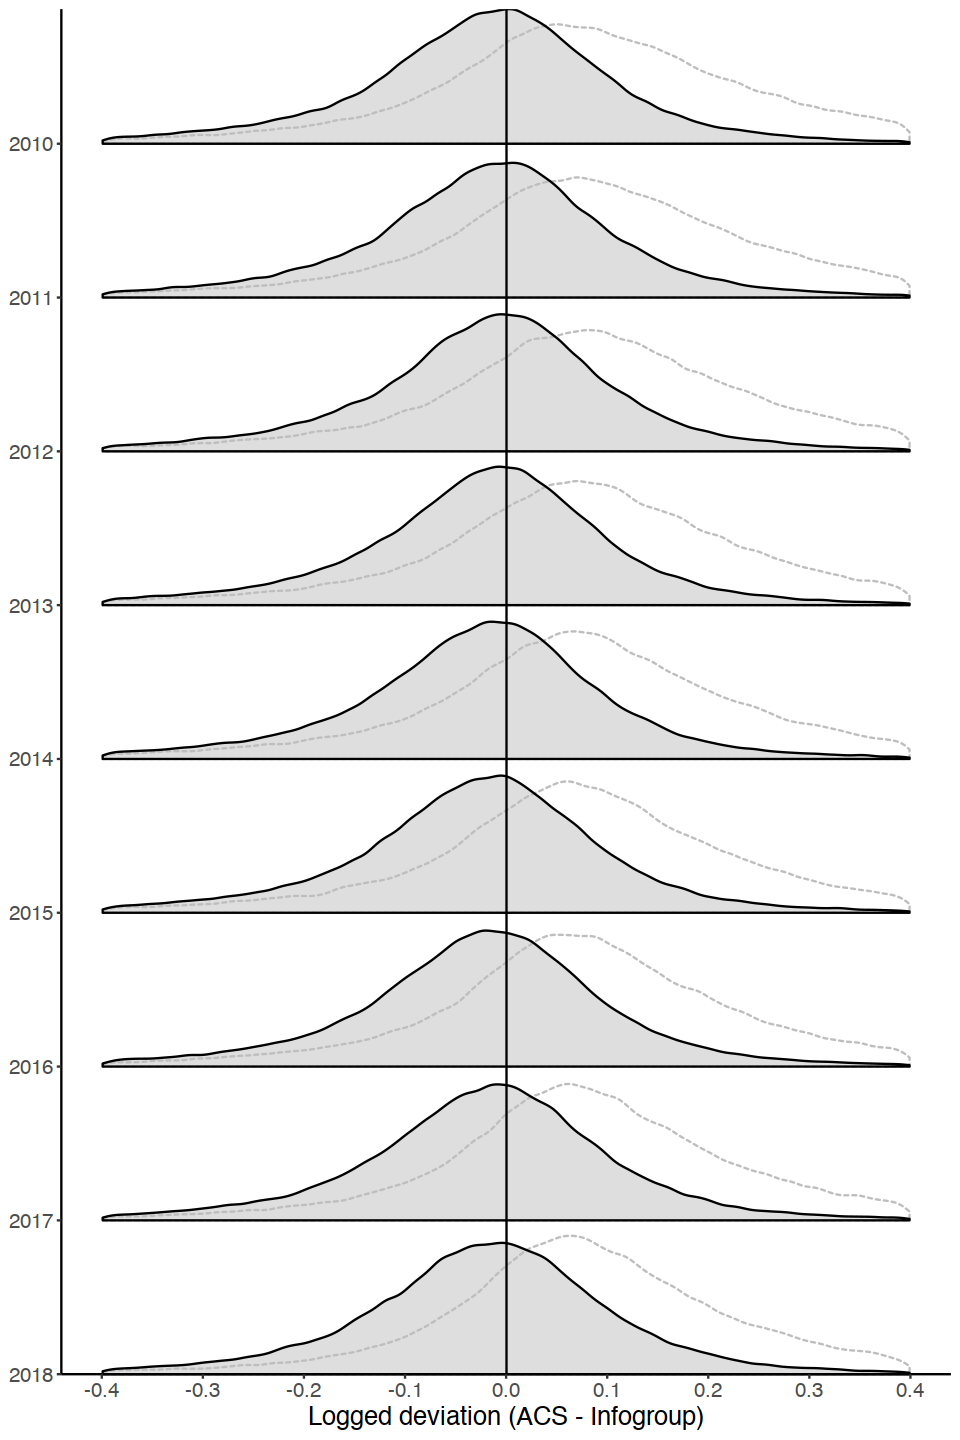

In [97]:
options(repr.plot.width=8, repr.plot.height=12)

projections_w_5year %>%
    mutate(dev = log(chh) - lprd_1_5year,
           dev2 = log(chh) - lig_5year) %>%
    ggplot(aes(x = dev, y = fct_rev(as_factor(year)))) +
     geom_density_ridges2(
        aes(x = dev2),
        fill = NA,
        color = "grey",
        linetype = "dashed",
        panel_scaling = TRUE,
        alpha = 0.5,
        scale = .9,
        bandwidth = 0.008
    ) +
    geom_density_ridges2(
        panel_scaling = FALSE,
        fill = "grey",
        alpha = .5,
        scale = .9,
        bandwidth = 0.008
    ) +
    geom_vline(xintercept = 0, color = 'black', linetype = "solid") +
    scale_x_continuous(
        limits = c(-.4, .4),
        name = "Logged deviation (ACS - Infogroup)",
        breaks = seq(-.4, .4, .1)
    ) +
    scale_y_discrete(expand = c(0, 0)) +
    theme_classic() +
    theme(
        text = element_text(size = 15),
        axis.title.y = element_blank()
    )

In [69]:
ggsave("../plots/tract_distributions.png", height = 8, width = 6)

Warning message:
“Removed 51172 rows containing non-finite values (stat_density_ridges).”
Warning message:
“Removed 22512 rows containing non-finite values (stat_density_ridges).”


In [105]:
# Get state, county names
county_names_lookup <- read_csv("../data/lookups/county_name_lookup.csv")
projections_w_5year <- projections_w_5year %>%
    left_join(county_names_lookup) %>%
    mutate("tractname" = paste0(
        str_sub(tractid, start = 6), ", ",
        name, ", ", state
    ))

Parsed with column specification:
cols(
  countyid = col_character(),
  name = col_character(),
  state = col_character()
)

Joining, by = "countyid"



In [ ]:
options(repr.plot.width=12, repr.plot.height=12)

plot_cases <- function(projections, tract_sample) {
    projections %>%
        filter(tractid %in% tract_sample) %>%
        ggplot() +
            geom_line(aes(x = year, y = lprd_1_5year)) +
            geom_point(aes(x = year, y = lprd_1_5year)) +
            geom_ribbon(
                aes(x = year, ymin = ll90_1_5year, ymax = lu90_1_5year),
                alpha = 0.2
            ) +
            geom_line(
                aes(x = year, y = log(ig_count_imptd_5year)),
                linetype = 'dashed'
            ) +
            geom_line(
                aes(x = year, y = log(chh)),
                color = 'grey20'
            ) +
            geom_ribbon(
                aes(x = year, ymin = lacs_lower, ymax = lacs_upper),
                alpha = 0.4,
                fill = 'grey20'
            ) +
            facet_grid(. ~ tractname) +
            scale_y_continuous(name = "Log (Population)") +
            scale_x_continuous(breaks = seq(2009, 2017, 3)) +
            theme_classic() +
            theme(
                text = element_text(size = 15),
                axis.title.x = element_blank()
            )
}

In [ ]:
# split the data by population decile
tractid_decile <- projections_w_5year %>%
    group_by(tractid) %>%
    summarize(acs_mean = mean(log(chh))) %>%
    mutate(acs_quartile = quantcut(acs_mean, q = 10, na.rm = TRUE))
levels(tractid_decile$acs_quartile) <- c(1:10)

# first row should be top decile
top_tract_decile <- tractid_decile %>%
    filter(acs_quartile == '10') %>%
    sample_n(5) %>%
    .$tractid %>%
    unique()
p1 <- plot_cases(projections_w_5year, top_tract_decile) +
    ggtitle("Top Decile")

# second row from middle quintile
mid_tract_quintile <- tractid_decile %>%
    filter(acs_quartile %in% c("5", "6")) %>%
    sample_n(5) %>%
    .$tractid %>%
    unique()
p2 <- plot_cases(projections_w_5year, mid_tract_quintile) +
    ggtitle("Middle Quintile")

# bottom row from lowest decile
bot_tract_decile <- tractid_decile %>%
    filter(acs_quartile == 1) %>%
    sample_n(5) %>%
    .$tractid %>%
    unique()
p3 <- plot_cases(projections_w_5year, bot_tract_decile) +
    ggtitle("Bottom Decile")

p1 / p2 / p3

In [117]:
ggsave("../plots/tract_random_sample.png", device = "png", height = 10, width = 10)